In [1]:
import numpy as np
import numpy.linalg as npla
import scipy
import scipy.linalg as sla
import pickle
import os
from sklearn.datasets import load_svmlight_file

from methods import GradientDescent, Newton, Nesterov, RBFGS, LBFGS, BFGS
from methods.rbfgs import Uniform, Gaussian, CustomDiscrete
from oracles import LogRegL2Oracle, create_log_reg_oracle, QuadraticOracle
from utils import select_basis_columns, run_rbfgs_experiment, run_all_methods

In [2]:
file = './datasets/w8a.txt'
A, b = load_svmlight_file(file, n_features=None)
regcoef = 1 / b.size
oracle = create_log_reg_oracle(A, b, 1 / b.size)

In [3]:
%%time
sketch_sizes = [1, 2, 3, 5, 10, 50, 100, 300]
run_all_methods(
    oracle=oracle, 
    sketch_sizes=sketch_sizes, 
    max_iter=1000, 
    mat=A.toarray(), 
    output_folder='./results/w8a/regcoef={:.2e}'.format(regcoef), 
    sigma_tolerance=1e-8, 
    method_tolerance=1e-16, 
    stopping_criteria='grad_abs', 
    random_state=0
)

Singular values above tolerance: 266

RBFGS-SVD sketch... 

/home/rogozia/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Done
RBFGS-uniform... Done
RBFGS-gauss... Done
BFGS... Done
Nesterov...Done

All runs completed.
CPU times: user 13h 53min, sys: 30min 12s, total: 14h 23min 12s
Wall time: 21min 23s


In [10]:
from utils import read_results_from_files
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

In [28]:
line_search_method = 'wolfe'
folder = './results/w8a/regcoef=2.01e-05/'
filenames = [
    '{}/rbfgs_svd_linesearch={}.pkl'\
        .format(folder, line_search_method), 
    '{}/rbfgs_uni_linesearch={}.pkl'\
        .format(folder, line_search_method), 
    '{}/rbfgs_gauss_linesearch={}.pkl'\
        .format(folder, line_search_method), 
    '{}/bfgs_linesearch={}.pkl'\
        .format(folder, line_search_method), 
    '{}/nesterov.pkl'.format(folder), 
]
results = dict(zip(
    ['svd', 'uni', 'gauss', 'bfgs', 'nesterov'], 
    read_results_from_files(filenames)
))

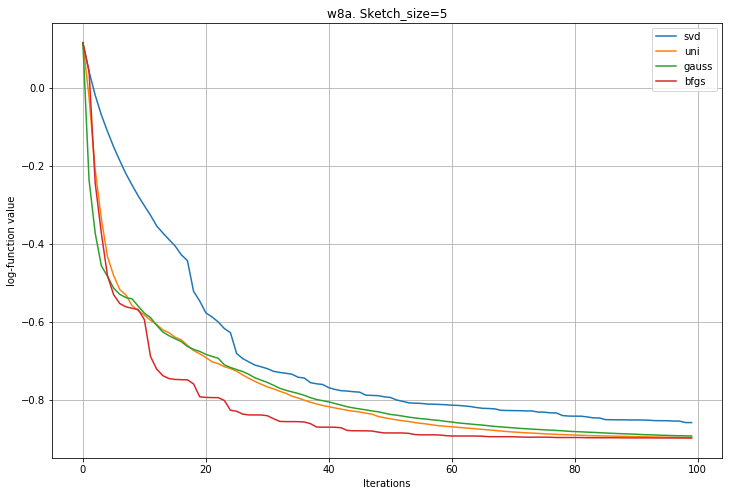

In [66]:
sketch_size = 5
hist_len = 100
plt.title('w8a. Sketch_size={}'.format(sketch_size))
plt.plot(np.log10(results['svd'][sketch_size].hist['func'][:hist_len]), label='svd')
plt.plot(np.log10(results['uni'][sketch_size].hist['func'][:hist_len]), label='uni')
plt.plot(np.log10(results['gauss'][sketch_size].hist['func'][:hist_len]), label='gauss')
plt.plot(np.log10(results['bfgs'].hist['func'][:hist_len]), label='bfgs')
# plt.plot(np.log10(results['nesterov'].hist['func'][:hist_len]), label='nesterov')

plt.xlabel('Iterations')
plt.ylabel('log-function value')
plt.legend()
plt.grid()

In [50]:
sketch_sizes

[1, 2, 3, 5, 10, 50, 100, 300]

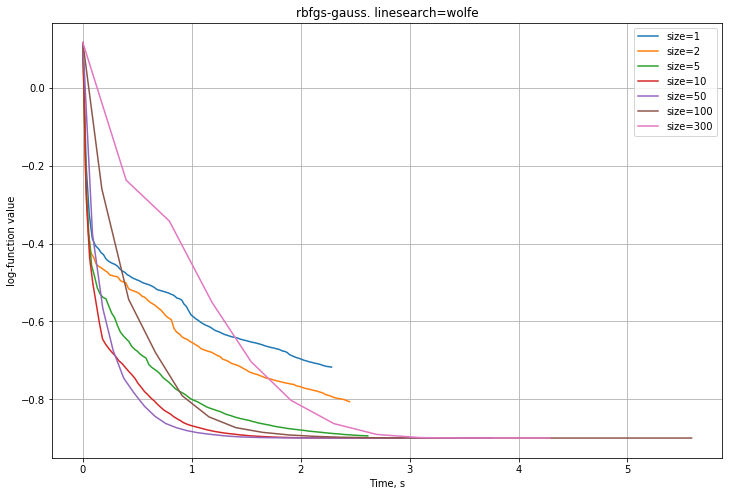

In [64]:
method_name = 'gauss'
against = 'time'
hist_len = 100

plt.title('rbfgs-gauss. linesearch={}'.format(line_search_method))

for sketch_size, res in results[method_name].items():
    if sketch_size not in [1, 2, 5, 10, 50, 100, 300]:
        continue
    if against == 'scaled_iterations':
        xgrid = np.arange(0, sketch_size * len(res.hist['func'][:hist_len]), sketch_size)
    elif against == 'iterations':
        xgrid = range(len(res.hist['func'][:hist_len]))
    elif against == 'time':
        xgrid = res.hist['time'][:hist_len]
    plt.plot(xgrid, np.log10(res.hist['func'][:hist_len]), 
             label='size={}'.format(sketch_size))

if against in ['iterations', 'scaled_iterations']:
    plt.xlabel('Iterations')
elif against == 'time':
    plt.xlabel('Time, s')
plt.ylabel('log-function value')
plt.legend()
plt.grid()